In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Dec 20 20:31:21 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#DCGAN
Code from the paper "Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks". 

#Dataset
I'll be using the CelebA dataset as the ground truth for the probability distribution. The GAN will be trained to generate faces.

In [2]:
!git clone https://github.com/tkarras/progressive_growing_of_gans.git

Cloning into 'progressive_growing_of_gans'...
remote: Enumerating objects: 170, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 170 (delta 1), reused 2 (delta 0), pack-reused 164
Receiving objects: 100% (170/170), 356.84 KiB | 15.51 MiB/s, done.
Resolving deltas: 100% (87/87), done.


In [3]:
!gdown --id 12rFbtWMg1NUCW4JKm_dwBpGdb6e-BuHg

Downloading...
From: https://drive.google.com/uc?id=12rFbtWMg1NUCW4JKm_dwBpGdb6e-BuHg
To: /content/CelebA.zip
100% 1.44G/1.44G [00:15<00:00, 94.5MB/s]


In [4]:
!unzip "/content/CelebA.zip" -d "/content/CelebA"

Streaming output truncated to the last 5000 lines.
 extracting: /content/CelebA/img_align_celeba/197600.jpg  
 extracting: /content/CelebA/img_align_celeba/197601.jpg  
 extracting: /content/CelebA/img_align_celeba/197602.jpg  
 extracting: /content/CelebA/img_align_celeba/197603.jpg  
 extracting: /content/CelebA/img_align_celeba/197604.jpg  
 extracting: /content/CelebA/img_align_celeba/197605.jpg  
 extracting: /content/CelebA/img_align_celeba/197606.jpg  
 extracting: /content/CelebA/img_align_celeba/197607.jpg  
 extracting: /content/CelebA/img_align_celeba/197608.jpg  
 extracting: /content/CelebA/img_align_celeba/197609.jpg  
 extracting: /content/CelebA/img_align_celeba/197610.jpg  
 extracting: /content/CelebA/img_align_celeba/197611.jpg  
 extracting: /content/CelebA/img_align_celeba/197612.jpg  
 extracting: /content/CelebA/img_align_celeba/197613.jpg  
 extracting: /content/CelebA/img_align_celeba/197614.jpg  
 extracting: /content/CelebA/img_align_celeba/197615.jpg  
 extr

In [5]:
!pip install tensorflow
!pip install tensorflow_datasets

In [6]:
!sudo du CelebA
!sudo ls CelebA/img_align_celeba | wc -l

1743844	CelebA/img_align_celeba
1743848	CelebA
202599


In [7]:
# Define Generator and Discriminator

import tensorflow as tf

FINAL_DIM = 16
IMAGE_RES = 64
NOISE_DIM = 100

def Generator():
      
  def add_g_layer(x, filters):
    """
    Generator layers are made up of a fractionally-strided convolution 
    ("deconvolution"), BatchNorm, and ReLU activation. 
    """
    x = tf.keras.layers.Conv2DTranspose(filters, kernel_size=(5, 5), 
                                        strides=(2, 2), padding='same', 
                                        activation=None)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    return x

  def output_g_layer(x):
    # Final fractionally-strided convolution ("deconvolution") into image space
    x = tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=(5, 5), 
                                        strides=(2, 2), padding='same', 
                                        activation=None)(x)
    x = tf.math.tanh(x)
    return x

  # Define input noise vector shape
  noise_input = tf.keras.layers.Input(shape=(NOISE_DIM))

  # Initial projection into 4x4 feature maps
  x = tf.keras.layers.Dense(4 * 4 * (FINAL_DIM * 8), 
                            activation=None)(noise_input)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Reshape((4, 4, (FINAL_DIM * 8)))(x)

  # Generator fractionally-strided convolutional layers
  x = add_g_layer(x, filters=FINAL_DIM * 4)
  x = add_g_layer(x, filters=FINAL_DIM * 2)
  x = add_g_layer(x, filters=FINAL_DIM)

  # Final convolution (convert feature maps into image)
  x = output_g_layer(x)

  # Model definition
  model = tf.keras.Model(inputs=noise_input, outputs=x, name='DCGAN_Generator')

  print(model.summary())

  return model


def Discriminator():

  """
  The Discriminator, for the most part, mirrors, the Generator. Key differences
  are 1) LeakyReLU(0.2) instead of ReLU, and 2) Output FC layer(1) with sigmoid
  activation.
  """

  def add_d_layer(x, filters):
    """
    Discriminator layers are made up of a strided convolutional layer 
    (downsampling without pooling), BatchNorm, and LeakyReLU (leak=0.2)
    """
    x = tf.keras.layers.Conv2D(filters, kernel_size=(5, 5), strides=(2, 2), 
                               padding='same', activation=None)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    return x

  def output_d_layer(x):
    """
    Final layer in Discriminator. Single neuron with sigmoid activation for
    classification of image as fake or real. 
    """
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.math.sigmoid(x)
    return x

  """Start: Image of dimensions (64, 64, 3). End: Fake/real classification value 
  ranging [0, 1]"""

  image_input = tf.keras.layers.Input(shape=(IMAGE_RES, IMAGE_RES, 3))

  # Discriminator's strided convolutions
  x = add_d_layer(image_input, filters=FINAL_DIM)
  x = add_d_layer(x, filters=FINAL_DIM * 2)
  x = add_d_layer(x, filters=FINAL_DIM * 4)
  x = add_d_layer(x, filters=FINAL_DIM * 8)

  # Discriminator's output layer
  x = output_d_layer(x)

  model = tf.keras.Model(inputs=image_input, outputs=x, 
                         name='DCGAN_Discriminator')

  print(model.summary())

  return model

g = Generator()
d = Discriminator()


Model: "DCGAN_Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense (Dense)               (None, 2048)              206848    
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 reshape (Reshape)           (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 64)         204864    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 64)     

In [8]:
!pip install opencv-python

(218, 178, 3)


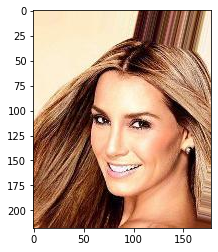

In [9]:
# Test image read

import cv2
import matplotlib.pyplot as plt

# Read in image as ndarray
img = cv2.imread('CelebA/img_align_celeba/000001.jpg')
# BGR -> RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Starting images are 178px resolution
print(img.shape)

# print(img)
plt.imshow(img)

(178, 178, 3)


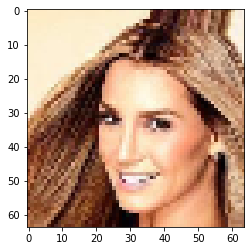

In [10]:

original_img = cv2.imread('CelebA/img_align_celeba/000001.jpg')

# Crop out top and bottom evenly to create a square image
crop_margin = int((original_img.shape[0] - original_img.shape[1]) / 2)
original_img = original_img[crop_margin:(original_img.shape[0] - crop_margin)]

print(original_img.shape)

# Resize to 64x64
img = cv2.resize(original_img, (64, 64))

# BGR -> RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)

In [11]:
!pip install tqdm

In [12]:
# I'm only going to take a subset of the data for now for training

SUBSET_AMOUNT = 10000

In [13]:
# Read images as dataset

import os
import numpy as np
from tqdm import tqdm

ds_list = []

directory = r'/content/CelebA/img_align_celeba'
for filename in tqdm(os.listdir(directory)[:SUBSET_AMOUNT]):

  if filename.endswith('.jpg'):

    # Read in image as ndarray
    img = cv2.imread('CelebA/img_align_celeba/' + filename)

    # Crop out top and bottom evenly to create a square image
    crop_margin = int((img.shape[0] - img.shape[1]) / 2)
    img = img[crop_margin:(img.shape[0] - crop_margin)]

    # Resize to 64x64
    img = cv2.resize(img, (64, 64))

    # BGR -> RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # ds = np.append(ds, img)
    ds_list.append(img)

ds = np.array(ds_list)

100%|██████████| 10000/10000 [00:17<00:00, 561.55it/s]


In [14]:
# Move all pixel values into the range [-1, 1] (the range of tanh)

ds = (ds / (255.0/2)) - 1.0

In [15]:
ds[0]

array([[[ 0.51372549,  0.41176471,  0.16078431],
        [ 0.55294118,  0.44313725,  0.19215686],
        [ 0.55294118,  0.46666667,  0.23137255],
        ...,
        [ 0.73333333,  0.7254902 ,  0.55294118],
        [ 0.76470588,  0.74901961,  0.58431373],
        [ 0.80392157,  0.78039216,  0.63137255]],

       [[ 0.51372549,  0.41176471,  0.16078431],
        [ 0.55294118,  0.45098039,  0.2       ],
        [ 0.56078431,  0.4745098 ,  0.24705882],
        ...,
        [ 0.74901961,  0.7254902 ,  0.56078431],
        [ 0.77254902,  0.75686275,  0.59215686],
        [ 0.79607843,  0.77254902,  0.62352941]],

       [[ 0.5372549 ,  0.43529412,  0.18431373],
        [ 0.56078431,  0.45882353,  0.20784314],
        [ 0.57647059,  0.49019608,  0.25490196],
        ...,
        [ 0.74901961,  0.73333333,  0.56862745],
        [ 0.78039216,  0.76470588,  0.6       ],
        [ 0.79607843,  0.77254902,  0.62352941]],

       ...,

       [[-0.34901961, -0.08235294,  0.46666667],
        [-0

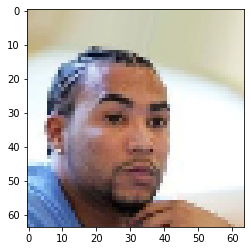

In [16]:
_ = (ds[0]+1.0)/2

plt.imshow(_)

#Training Loop

In [17]:
# Test noise input for Generator

def get_noise_samples(n_samples):
  return(np.random.rand(n_samples, 100))

rand_noise_vec = get_noise_samples(1)
rand_noise_vec

array([[0.6912633 , 0.57849053, 0.18253134, 0.76560236, 0.95422675,
        0.49464775, 0.06785085, 0.30415542, 0.4253121 , 0.91323989,
        0.03814837, 0.46605372, 0.68619126, 0.13370267, 0.58187943,
        0.66698806, 0.77167152, 0.4490932 , 0.23539806, 0.64514775,
        0.96163709, 0.90515083, 0.48186824, 0.02099945, 0.75925276,
        0.81464895, 0.53892167, 0.80587274, 0.20059171, 0.48767509,
        0.46514731, 0.07982873, 0.80630595, 0.54512489, 0.80091365,
        0.88913353, 0.91542956, 0.39404245, 0.74368045, 0.45777503,
        0.90189737, 0.9172034 , 0.55382597, 0.04843332, 0.55660358,
        0.60564746, 0.67054826, 0.04252575, 0.30572641, 0.77108176,
        0.54795465, 0.08860434, 0.87194744, 0.74658762, 0.38638149,
        0.22366914, 0.11539575, 0.17989266, 0.23475108, 0.96901527,
        0.30071719, 0.12662368, 0.1841491 , 0.13215579, 0.78083267,
        0.53074319, 0.63520028, 0.38745064, 0.6419594 , 0.33669645,
        0.33472591, 0.98541388, 0.59806173, 0.51

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


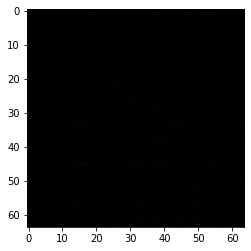

In [18]:
# Feed noise into G and see what we get

test_img = g(rand_noise_vec)

# print(test_img)

for img in test_img:
  plt.imshow(img)

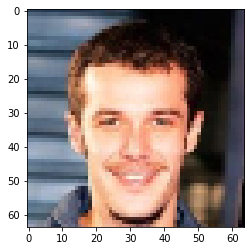

In [167]:
# Sampling random images from the dataset

def get_image_samples(n_samples):
  return(ds[np.random.randint(ds.shape[0], size=n_samples)])

plt.imshow((get_image_samples(10)[1]+1)/2)

In [130]:
g = Generator()
d = Discriminator()

Model: "DCGAN_Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 100)]             0         
                                                                 
 dense_24 (Dense)            (None, 2048)              206848    
                                                                 
 batch_normalization_108 (Ba  (None, 2048)             8192      
 tchNormalization)                                               
                                                                 
 reshape_12 (Reshape)        (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose_48 (Conv2D  (None, 8, 8, 64)         204864    
 Transpose)                                                      
                                                                 
 batch_normalization_109 (Ba  (None, 8, 8, 64)     

In [152]:
# Training loop

EPOCHS = 100
D_STEPS = 2
G_STEPS = 1
BATCH_SIZE = 128

# Set seed
np.random.seed(1)

# Optimizers
# d_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
# g_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
d_optimizer = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.5)
g_optimizer = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.5)

# Losses

# Format from https://www.tensorflow.org/tutorials/generative/dcgan:
def d_loss(real_predictions, fake_predictions):

  # Label all real predictions' ground truth as 1, compute b-crossentropy
  real_loss = tf.keras.losses.BinaryCrossentropy()(tf.ones_like(real_predictions), 
                                                   real_predictions)
  # Label all fake predictions' ground truth as 0, compute b-crossentropy
  fake_loss = tf.keras.losses.BinaryCrossentropy()(tf.zeros_like(fake_predictions),
                                                   fake_predictions)
  # Sum and return losses
  print(real_loss + fake_loss)
  return real_loss + fake_loss

def g_loss(d_values):

  # Binary Crossentropy between the Discriminator outputs and 1 (which we'd like 
  # the Discriminator outputs to be)
  loss = tf.keras.losses.BinaryCrossentropy()(tf.ones_like(d_values),
                                              d_values)
  return loss

# Training step definitions
# Compiled for training

@tf.function
def d_train_step():

  print('as')

  with tf.GradientTape() as d_tape:

    # Sample m noise samples
    noise_samples = get_noise_samples(BATCH_SIZE)

    # Get Generator examples from the noise
    g_examples = g(noise_samples)

    # Sample real examples from dataset
    data_examples = get_image_samples(BATCH_SIZE)

    # Run Discriminator and get loss
    loss = d_loss(d(data_examples, training=True), d(g_examples, training=True))

  # Get all Discriminator gradients with GradientTape
  d_grad = d_tape.gradient(loss, d.trainable_variables)

  # Apply gradients to model, zipping gradients with corresponding variables
  d_optimizer.apply_gradients(zip(d_grad, d.trainable_variables))

  print('d_step')

@tf.function
def g_train_step():

  # All steps of the process must be within for backpropagation to work
  with tf.GradientTape() as g_tape:

    # Sample m noise samples
    noise_samples = get_noise_samples(BATCH_SIZE)

    # Get Generator (fake) examples from the noise
    g_examples = g(noise_samples)

    # Run discriminator on generated samples
    d_values = d(g_examples, training=True)

    # Get loss
    loss = g_loss(d_values)

  # Use GradientTape to get all Generator gradients
  g_grad = g_tape.gradient(loss, g.trainable_variables)

  # Apply gradients
  g_optimizer.apply_gradients(zip(g_grad, g.trainable_variables))

@tf.function
def train_step():

  print('tstep')

  for j in range(D_STEPS):
    
    # Train Discriminator to distinguish between the two
    d_train_step()

  # for j in range(G_STEPS):

  #   # Train Generator to maximize the probability of tricking the discriminator
  #   g_train_step()


In [96]:
# reset_models()

Model: "DCGAN_Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 100)]             0         
                                                                 
 dense_18 (Dense)            (None, 2048)              206848    
                                                                 
 batch_normalization_81 (Bat  (None, 2048)             8192      
 chNormalization)                                                
                                                                 
 reshape_9 (Reshape)         (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose_36 (Conv2D  (None, 8, 8, 64)         204864    
 Transpose)                                                      
                                                                 
 batch_normalization_82 (Bat  (None, 8, 8, 64)     

In [131]:
# Train

def train(EPOCHS):

  for i in range(EPOCHS):

    train_step()
    print("EPOCH " + str(i))

train(100)

tstep
as
Tensor("add:0", shape=(), dtype=float32)
d_step
as
Tensor("add:0", shape=(), dtype=float32)
d_step
EPOCH 0
EPOCH 1
EPOCH 2
EPOCH 3
EPOCH 4
EPOCH 5
EPOCH 6
EPOCH 7
EPOCH 8
EPOCH 9
EPOCH 10
EPOCH 11
EPOCH 12
EPOCH 13
EPOCH 14
EPOCH 15
EPOCH 16
EPOCH 17
EPOCH 18
EPOCH 19
EPOCH 20
EPOCH 21
EPOCH 22
EPOCH 23
EPOCH 24
EPOCH 25
EPOCH 26
EPOCH 27
EPOCH 28
EPOCH 29
EPOCH 30
EPOCH 31
EPOCH 32
EPOCH 33
EPOCH 34
EPOCH 35
EPOCH 36
EPOCH 37
EPOCH 38
EPOCH 39
EPOCH 40
EPOCH 41
EPOCH 42
EPOCH 43
EPOCH 44
EPOCH 45
EPOCH 46
EPOCH 47
EPOCH 48
EPOCH 49
EPOCH 50
EPOCH 51
EPOCH 52
EPOCH 53
EPOCH 54
EPOCH 55
EPOCH 56
EPOCH 57
EPOCH 58
EPOCH 59
EPOCH 60
EPOCH 61
EPOCH 62
EPOCH 63
EPOCH 64
EPOCH 65
EPOCH 66
EPOCH 67
EPOCH 68
EPOCH 69
EPOCH 70
EPOCH 71
EPOCH 72
EPOCH 73
EPOCH 74
EPOCH 75
EPOCH 76
EPOCH 77
EPOCH 78
EPOCH 79
EPOCH 80
EPOCH 81
EPOCH 82
EPOCH 83
EPOCH 84
EPOCH 85
EPOCH 86
EPOCH 87
EPOCH 88
EPOCH 89
EPOCH 90
EPOCH 91
EPOCH 92
EPOCH 93
EPOCH 94
EPOCH 95
EPOCH 96
EPOCH 97
EPOCH 98
EPOCH 99


tf.Tensor(
[[[[-3.1960179e-05  1.8288071e-04  2.1218028e-05]
   [-2.7567334e-04 -3.8282928e-04 -1.4532410e-04]
   [-9.7170232e-06 -2.4760130e-04 -1.5856851e-04]
   ...
   [-5.3629733e-04 -8.0801685e-05 -1.1807962e-03]
   [-2.3844092e-04 -6.2391278e-04 -5.4139877e-05]
   [ 2.8843651e-04 -3.5078294e-04 -8.4486906e-04]]

  [[-1.9522040e-04 -1.3964102e-04  3.5722344e-04]
   [ 6.6272175e-04  1.7660699e-03  9.9723157e-04]
   [-6.7148788e-04 -3.9345861e-04  6.3962938e-04]
   ...
   [-9.1951841e-04  3.0037363e-03  1.5418559e-03]
   [-2.6048608e-03 -1.4049027e-04  3.3276505e-03]
   [ 2.3814323e-03  2.3600919e-04 -1.8539582e-04]]

  [[-1.6427360e-04  2.6566265e-04 -1.6553869e-04]
   [-1.9246305e-05  5.2038993e-04  5.7599664e-04]
   [-8.3288655e-04 -7.2789140e-04 -9.5240917e-05]
   ...
   [ 6.2347448e-04 -9.5655152e-04  2.3247602e-03]
   [-1.0193392e-03 -7.9468905e-04  2.9170322e-03]
   [ 8.7963027e-04  5.0295523e-04  9.5455197e-04]]

  ...

  [[-1.1935156e-03 -2.1179419e-04  7.7461055e-04]
   [-

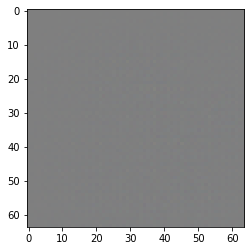

In [155]:
test_img = g(rand_noise_vec)

print(test_img)

for img in test_img:
  plt.imshow((img + 1)/2)

In [134]:
print(d(g(get_noise_samples(1))))

print(d(get_image_samples(1)))

tf.Tensor([[0.5000266]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.5000266]], shape=(1, 1), dtype=float32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


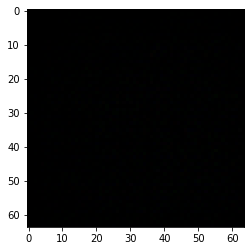

In [ ]:
plt.imshow(g_examples[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


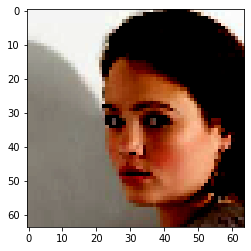

In [ ]:
plt.imshow(data_examples[0])

In [ ]:
# Prepare data

real_ds = tf.keras.utils.image_dataset_from_directory('/content/CelebA/img_align_celeba/', 
                                                      validation_split=0.1, 
                                                      subset='training', seed=1)


Found 0 files belonging to 0 classes.
Using 0 files for training.


ValueError: ignored

In [ ]:
# Load dataset

import tensorflow_datasets as tfds

ds = tfds.load('celeb_a', shuffle_files=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

KeyError: ignored